<a href="https://colab.research.google.com/github/SergioJF10/MLT-ESI-UCLM_CIS/blob/main/products/Notebooks/NLP/NLP_products.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing Project
In this collab, we will explain the different developments made for the Natural Language Processing (NLP) practice for the Machine Learning Techniques subject.

In [ ]:
%%capture
!pip install textblob
!pip install contractions
!pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download("popular")
import contractions
import copy
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from wordcloud import WordCloud
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn import model_selection, svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_regression

## First Steps: Importing and Preparing the data

Let's now take only those columns in which we are actually interested: `id`, `score`, `summary` and `text`. For this tasks we will just make a basic preprocess by means of Python file management.

First of all, we will define a method for concatenating those strings with the corresponding separator.

In [ ]:
def concat(to_concat, sep=','):
  concat = ''
  for i in range(len(to_concat)):
    concat += to_concat[i]
    if i < len(to_concat) - 1:
      concat += sep
  return concat

Now, we have to process the file. First of all, we remove all the unnecesary tokens, such as quotation marks and the newline separator. Once those are removed, we split all the fields according to the CSV separator, the comma `,`. 

Once we have done that, we just need the last part of the array, which actually contains what we need. But in fact, there is even a field that we don't need, so we cut it.

Note that is possible to find in the `Text` field several commas which had been splitted previously, so if it has occured, we concatenate them using the previous method.

Finally, in the array `filtered` we have the proper data to be used.

In [ ]:
with open('products.csv', 'r', encoding='utf-8') as raw:
  lines = raw.readlines()
  
  filtered = []
  i = 0
  for line in lines:
    semicolon = line.replace(';;;;;;;;;;;;;;;;;;;;;;;;', '')
    quotes = semicolon.replace('"', '')
    splitted = quotes.split(',')
    shorter = [splitted[0]] + splitted[6:]
    no_time = shorter[:2] + shorter[3:]

    if len(no_time) > 4:
      no_time = no_time[:3] + [concat(no_time[3:])]

    filtered.append(no_time)

If we remember, both fields `Text` and `Summary` should be joined in just one field.

In [ ]:
joined = [['Id', 'Score', 'SummaryText']]
for line in filtered[1:]:
  if len(line) > 1:
    ready = line[:2] + [concat([line[2], line[3]], '.')]
    joined.append(ready)

joined[:3]

[['Id', 'Score', 'SummaryText'],
 ['1',
  '5',
  'Good Quality Dog Food.I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.\n'],
 ['2',
  '1',
  'Not as Advertised.Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as Jumbo.\n']]

Once we have a list of properly labeled documents, we can now go deeper with the preprocessing.

## 1. Preprocessing
For the preprocessing, we can group some steps in one single loop for optimizing the process, like:
  - **Useless characters**: From the list `[]!_$%&/()=^*¡@<>`.
  - **Capital letters**: Making all of them into lower case.
  - **Useless tokens**: HTML tags (they may also contain URLs).
  - **Expand contractions**: By means of the [contractions](https://pypi.org/project/contractions/) library.
  - **Remove emojis**: In this case, we don't need them.
  - **Remove numbers**: In this case, we don't need them neither.
  - **Spell Checking**: And try to correct them. Due to the long execution time, it is commented (last two lines of the for loop).

In [ ]:
emoji = u"['\U0001F300-\U0001F5FF'|'\U0001F600-\U0001F64F'|'\U0001F680-\U0001F6FA'|'\u260E-\u26FF-\u2700-\u27BF']"

for i in tqdm(range(1, len(joined))):
  joined[i][2] = re.sub(r'[\[\]!_$%&/()=^*¡@?]', '', joined[i][2]) # useless characters
  joined[i][2] = joined[i][2].lower() # capital letters
  joined[i][2] = re.sub(r'<.*?>', '', joined[i][2]) # HTML tags
  joined[i][2] = contractions.fix(joined[i][2]) # expand contractions
  joined[i][2] = re.sub(emoji, '', joined[i][2]) # remove emojis
  joined[i][2] = re.sub('[0-9]+', '', joined[i][2])
  #new_doc = TextBlob(joined[i][2])
  #joined[i][2] = new_doc.correct() # spell checking

print(joined[43]) # useless characters ++ capital letters
print(joined[349]) # HTML tags solved
print(joined[11]) # contractions solved

100%|██████████| 50822/50822 [00:03<00:00, 13145.91it/s]

['43', '5', 'foodgreat.i have mccanns oatmeal every morning and by ordering it from amazon i am able to save almost . per box.it is a great product. tastes great and very healthy\n']
['349', '5', 'good stuff.these are delicious the chocolate is excellent and the espresso bean was the perfect roast for this purpose. crunchy and not bitter.chocolate covered espresso beans  pounds\n']
['11', '5', 'the best hot sauce in the world.i do not know if it is the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind  we picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away  when we realized that we simply could not find it anywhere in our city we were bummed.now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.if you love hot sauce..i mean really love hot sauce, but do not want a sauce that tastelessly burns your throat, grab 

Now, we should split by blank spaces. But we should take into account that they might appear several sequential spaces, commas or even dots (and many more), so we can use the following code to split the words.

In [ ]:
docs_words = [['Id', 'Score', 'SummaryText']]
for i in range(1, len(joined)):
  line = [joined[i][0], joined[i][1]]
  words = re.split(r'[ .,:-]+', joined[i][2])
  line.append(words)
  docs_words.append(line)

print(docs_words[2])

['2', '1', ['not', 'as', 'advertised', 'product', 'arrived', 'labeled', 'as', 'jumbo', 'salted', 'peanuts', 'the', 'peanuts', 'were', 'actually', 'small', 'sized', 'unsalted', 'not', 'sure', 'if', 'this', 'was', 'an', 'error', 'or', 'if', 'the', 'vendor', 'intended', 'to', 'represent', 'the', 'product', 'as', 'jumbo', '\n']]


Now, we can continue with **removing repeated words**, by means of a simple double loop and checking if the current word is equal to the next one (if it not the last one).

In [ ]:
for i in range(1, len(docs_words)):
  no_rep = []
  for j in range(1, len(docs_words[i][2])):
    if j + 1 < len(docs_words[i][2]):
      if docs_words[i][2][j] == docs_words[i][2][j + 1]:
        continue
    no_rep.append(docs_words[i][2][j])
  docs_words[i][2] = copy.deepcopy(no_rep)

print(docs_words[1823][2])

['crunch', 'solution', 'i', 'happened', 'upon', 'this', 'item', 'in', 'my', 'local', 'deli', 'and', 'being', 'curios', 'i', 'decided', 'to', 'try', 'they', 'were', 'fabulous', 'better', 'than', 'the', 'regular', 'chips', 'by', 'far', 'i', 'gives', 'you', 'satisfaction', 'of', 'crunch', 'and', 'flavor', 'in', 'a', 'potatoe', 'chip', 'great', 'find', '\n']


As we can see, the repeated words have been removed correctly. Let's check via a word cloud a quick visualization of the current top words.

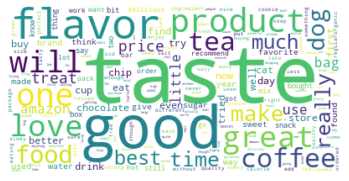

In [ ]:
vocab = ''
for doc in docs_words:
  vocab += concat(doc[2], sep=' ')
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(vocab)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

As we can see, there are a lot of words that might come in handy. But, aiming to improve the representativity of the vocabulary, we are going to remove the stopwords in order to reduce unsignificant words. Note that this can also take a while.

In [ ]:
stops = stopwords.words()
docs_vocab = [['Id', 'Score', 'SummaryText']]
for i in tqdm(range(1, len(docs_words))):
  line = [docs_words[i][0], docs_words[i][1]]
  no_stop = [w for w in docs_words[i][2] if not w in stops]
  line.append(no_stop)
  docs_vocab.append(line)

print(docs_vocab[2])

100%|██████████| 50822/50822 [11:27<00:00, 73.93it/s]

['2', '1', ['advertised', 'product', 'arrived', 'labeled', 'jumbo', 'salted', 'peanuts', 'peanuts', 'small', 'sized', 'unsalted', 'error', 'vendor', 'intended', 'represent', 'product', 'jumbo', '\n']]


Now, we are going to lemmatize the vocabulary of eacy document.

In [ ]:
lemmatizer = WordNetLemmatizer()
vocabularies = []
for i in tqdm(range(1, len(docs_vocab))):
  line = [docs_vocab[i][0], docs_vocab[i][1]]
  line.append([lemmatizer.lemmatize(t, pos='a') for t in docs_vocab[i][2]])
  vocabularies.append(line)
print(vocabularies[0][2])

100%|██████████| 50822/50822 [00:08<00:00, 5929.80it/s]

['quality', 'food', 'bought', 'vitality', 'canned', 'food', 'products', 'found', 'quality', 'product', 'stew', 'processed', 'meat', 'smells', 'labrador', 'finicky', 'appreciates', 'product', '\n']


Let's now generate a final word cloud.

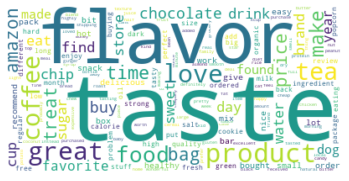

In [ ]:
vocab = ''
for doc in vocabularies:
  vocab += concat(doc[2], sep=' ')
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(vocab)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Once we have a final preprocessing, is time to create appropriate arrays to move on with the next steps.

In [ ]:
docs = []
labels = []
ignored = 0
for doc in vocabularies:
  if not doc[1] in ['1','2','3','4','5']:
    ignored += 1
  else:
    docs.append(concat(doc[2][:-1], ' '))
    labels.append(doc[1])
print(f'{ignored} entries ignored due to parsing errors')

x_train, x_test, y_train, y_test = model_selection.train_test_split(docs, labels, test_size=0.3, shuffle=False)

print(x_train[:6])
print(y_train[:6])

230 entries ignored due to parsing errors
['quality food bought vitality canned food products found quality product stew processed meat smells labrador finicky appreciates product', 'advertised product arrived labeled jumbo salted peanuts peanuts small sized unsalted error vendor intended represent product jumbo', 'confection centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch', 'medicine secret ingredient robitussin believe found addition root beer extract ordered made cherry soda flavor medicinal', 'taffy great taffy great price wide assortment yummy taffy delivery quick taffy lover deal', 'taffy wild hair taffy ordered pound bag taffy enjoyable flavors watermelon root beer melon peppermint grape complaint bit redblack licoriceflavored pieces particular favorites kids husban

## 2. Vectorization and model training
For the vectorization and model training, we thought in 4 approaches:

1. TF-IDF Vectorization.
2. TF-IDF Vectorization and N-grams.
3. TF-IDF Vectorization and POS tagging.
4. TF-IDF Vectorization, POS tagging, number of words and number of sentences.

We did not accumulate the N-grams for lines 3 and 4 due to the high RAM memory demand of using N-grams with our data.

Before checking those notebooks, we consider interesing studying the balance of the data.

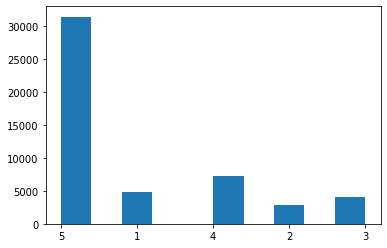

In [ ]:
plt.hist(labels)
plt.show()

As we can see, we have such a big imbalance that should be taken into account when using the data.

### 2.1 Persistance Section
For the next notebooks, we need to store the data so we can load them when needed.

We will use JSON format, since by this way, we can simply store the arrays and load them by just using json.load, so there is no need to develop a file processing method.

In [ ]:
with open('x_train.json', 'w', encoding='utf-8') as x_train_file:
  json.dump(x_train, x_train_file)
with open('x_test.json', 'w', encoding='utf-8') as x_test_file:
  json.dump(x_test, x_test_file)
with open('y_train.json', 'w', encoding='utf-8') as y_train_file:
  json.dump(y_train, y_train_file)
with open('y_test.json', 'w', encoding='utf-8') as y_test_file:
  json.dump(y_test, y_test_file)

By this way, this will create 4 files with the data indicated as the file name.

They will be the input to the other Google Colab notebooks in the "Notebooks/Models" folder.